In [1]:
from keras.applications import MobileNet
import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from keras.preprocessing import image
from os import listdir
from os.path import isfile, join
import re
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
# MobileNet was designed to work on 224 x 224 pixel input images sizes
img_rows, img_cols = 224, 224 

# Re-loads the MobileNet model without the top or FC layers
MobileNet = MobileNet(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in MobileNet.layers:
    layer.trainable = False
    
for (i,layer) in enumerate(MobileNet.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 ZeroPadding2D False
2 Conv2D False
3 BatchNormalization False
4 ReLU False
5 DepthwiseConv2D False
6 BatchNormalization False
7 ReLU False
8 Conv2D False
9 BatchNormalization False
10 ReLU False
11 ZeroPadding2D False
12 DepthwiseConv2D False
13 BatchNormalization False
14 ReLU False
15 Conv2D False
16 BatchNormalization False
17 ReLU False
18 DepthwiseConv2D False
19 BatchNormalization False
20 ReLU False
21 Conv2D False
22 BatchNormalization False
23 ReLU False
24 ZeroPadding2D False
25 DepthwiseConv2D False
26 BatchNormalization False
27 ReLU False
28 Conv2D False
29 BatchNormalization False
30 ReLU False
31 DepthwiseConv2D False
32 BatchNormalization False
33 ReLU False
34 Conv2D False
35 BatchNormalization False
36 ReLU False
37 ZeroPadding2D False
38 DepthwiseConv2D False
39 BatchNormalization False
40 ReLU False
41 Conv2D False
42 BatchNormalization False
43 ReLU False
44 DepthwiseConv2D False
45 BatchNormalization False
46 ReLU False
47 Conv2D False
48 Batc

In [3]:
def addTopModelMobileNet(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [4]:
num_classes = 10

FC_Head = addTopModelMobileNet(MobileNet, num_classes)

model = Model(inputs = MobileNet.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [5]:
train_data_dir = 'celebrity_dataset/training'
validation_data_dir = 'celebrity_dataset/testing'

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=45, width_shift_range=0.3, height_shift_range=0.3,
                                   horizontal_flip=True, fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
batch_size = 64
 
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size,
                                                    class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=batch_size, class_mode='categorical')

Found 80 images belonging to 10 classes.
Found 20 images belonging to 10 classes.


In [6]:
checkpoint = ModelCheckpoint("face_recog_adam1.h5", monitor="val_loss", mode="min", 
                             save_best_only = True, verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5, verbose = 1, restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks = [earlystop, checkpoint, reduce_lr]

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.001), metrics = ['accuracy'])

nb_train_samples = 160
nb_validation_samples = 20

epochs = 10
batch_size = 8

history = model.fit_generator(train_generator, steps_per_epoch = nb_train_samples // batch_size, epochs = epochs,
                              callbacks = callbacks, validation_data = validation_generator,
                              validation_steps = nb_validation_samples // batch_size)

Epoch 1/10
20/20 [==============================] - 1051s 53s/step - loss: 1.9595 - accuracy: 0.3887 - val_loss: 2.7928 - val_accuracy: 0.1500

Epoch 00001: val_loss improved from inf to 2.79279, saving model to face_recog_adam1.h5
Epoch 2/10
20/20 [==============================] - 989s 49s/step - loss: 0.6222 - accuracy: 0.8275 - val_loss: 4.0451 - val_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 2.79279
Epoch 3/10
20/20 [==============================] - 850s 42s/step - loss: 0.2348 - accuracy: 0.9488 - val_loss: 4.8355 - val_accuracy: 0.3000

Epoch 00003: val_loss did not improve from 2.79279
Epoch 4/10
20/20 [==============================] - 864s 43s/step - loss: 0.1813 - accuracy: 0.9463 - val_loss: 4.5688 - val_accuracy: 0.3500

Epoch 00004: val_loss did not improve from 2.79279

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/10
20/20 [==============================] - 479s 24s/step - loss: 0.0498 - accuracy: 0.9887 - va

In [7]:
model.save("face_recog_adam1.h5")

In [8]:
from keras.models import load_model


In [9]:
m1 = load_model('face_recog_adam1.h5')

In [10]:
class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(classes)

['Shraddha', 'alia', 'ananya', 'katrina', 'kriti', 'sara', 'shilpa', 'sonakshi', 'sonam', 'tapsee']


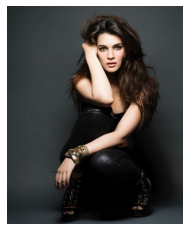

Predicted:  katrina
True:  kriti

---------------------------------------------------


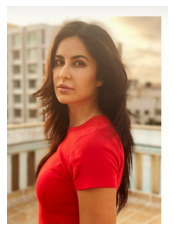

Predicted:  Shraddha
True:  katrina

---------------------------------------------------


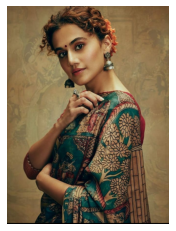

Predicted:  katrina
True:  tapsee

---------------------------------------------------


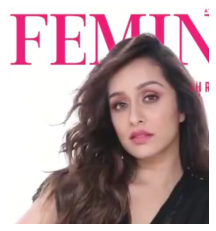

Predicted:  Shraddha
True:  Shraddha

---------------------------------------------------


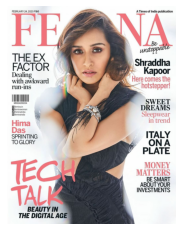

Predicted:  Shraddha
True:  Shraddha

---------------------------------------------------


In [11]:
# checking model on validation data
def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our validation path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 224, 224

files = []
predictions = []
true_labels = []

# predicting images
for i in range(0, 5):
    path = 'celebrity_dataset/testing/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = np.argmax(m1.predict(images, batch_size = 10))
    predictions.append(classes)
    
for i in range(0, len(files)):
    img=mpimg.imread((files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Predicted: ",class_labels[predictions[i]])
    print("True: ",true_labels[i])
    print("\n---------------------------------------------------")

In [12]:
m2 = load_model('face_recog_adam1.h5')

In [13]:
def check_1(path):
    img=mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # prediction
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x.astype('float32')/255
    pred = np.argmax(m1.predict(x))
    pred1 = np.argmax(m2.predict(x))
    print("(Adam)It's a {}.".format(class_labels[pred])) 
    

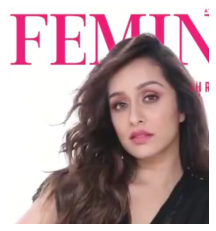

(Adam)It's a Shraddha.


In [14]:
check_1('Shraddha\S.png')